# VOR decoder in Python

This is a pure Python implementation of the VOR decoder.

I did not write this code, it is just a cleaned up version of the code I found on the internet that was written by [martinber](https://github.com/martinber), I just tested it and added some comments to make it easier to understand.

In [1]:
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DECIMATED_RATE = 6000

## WAV file recording

The recording is a WAV file that contains a VOR signal. The VOR signal is a type of radio navigation system used by aircraft to determine their position relative to a VOR station.

The signal should be recorded in a way that captures the full VOR signal, including the reference and variable signals. In my testing, I used SDRUno which was tuned to the carrier signal of the VOR station, the software should be set to AM mode with a bandwith big enough to capture both the AM signal and the FM subcarrier (something around 22KHz).

In [3]:
FILENAME = "./audio/20250710-2057.wav"

## Analyzing the VOR Angle Offset Issue

I think the `ANGLE_OFFSET` is needed due to a minor issue, related to phase alignment between the reference and variable signals in the VOR decoder.

### The Root Cause

The offset is needed because:

1. In the `compare_phases()` function, there's a mismatch between the expected phase relationship and the actual phase relationship between your reference and variable signals
2. The original developer (https://github.com/martinber/vor-python-decoder) noticed that the bearing calculation was consistently off by around 114 degrees
3. Rather than resolving the underlying mathematical or signal processing issue, a constant offset was applied as a temporary fix

### Where the Offset is Applied

The offset is used in the `compare_phases()` function:

This code converts the angle offset to a time delay by:

1. Converting the angle to a fraction of a full rotation (`ANGLE_OFFSET / 360`)
2. Multiplying by the period of a 30Hz signal (`1/30`)
3. Converting to samples by multiplying by the sample rate
4. Shifting the variable signal by this many samples

### Potential Root Causes

The phase mismatch could be due to:
1. Signal processing delays not being properly accounted for
2. Phase shifts introduced by the various filters (most likely)
3. Initial phase differences in the reference and variable signals
4. Differences between theoretical VOR signal structure and the actual recorded signal
5. Alignment issues in the correlation calculation

This is a common approach in signal processing projects - adding calibration constants when the theoretical and practical implementations don't perfectly align.

To calculate the angle offset, I used the following formula:

```python
new_offset = current_offset + (desired_bearing - current_bearing)
```

In [54]:

# Constant used for tuning - calibrated for my position
ANGLE_OFFSET = 216

In [37]:
class Signal:

    def __init__(self, samples, rate, delay=0):
        """
        Keeps the data of a signal and sample rate tied together.

        Also keeps track of the delay that this signal has, each FIR filter adds
        a delay of N/2 being N the number of taps. At the end I need the delays
        of each signal to compare the phase of them.
        """
        self.samples = samples
        self.rate = rate
        self.delay = delay

## The `lowpass` filter

The `lowpass()` function in this code implements a finite impulse response (FIR) low-pass filter, which is a critical component in signal processing for VOR decoding. Let me explain this method in detail:

### Basic Purpose

The low-pass filter allows frequencies below a cutoff point to pass through while attenuating higher frequencies. In this VOR decoder, this is essential for:

1. Isolating the reference 30Hz tone from the input signal
2. Removing high-frequency noise from the FM subcarrier after demodulation

### Function Parameters

```python
def lowpass(signal, width, attenuation, f):
    """
    FIR lowpass filter.
    
    Updates the delay attribute of the Signal object, indicating the delay that
    this filter has created.
    
    Arguments:
    - signal: Signal object
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f [Hz]: Cutoff frequency
    """
```

- **signal**: A `Signal` object containing samples, rate, and accumulated delay
- **width**: Width of the transition band in Hz (how quickly the filter transitions from pass to stop)
- **attenuation**: Desired stopband attenuation in dB (higher means stronger filtering)
- **f**: Cutoff frequency in Hz (frequencies below this pass through)

### Technical Implementation

#### 1. Nyquist Rate Calculation

```python
nyq_rate = signal.rate / 2
```
The Nyquist rate is half the sample rate, representing the highest frequency that can be represented in a sampled signal.

#### 2. Normalization of Parameters

```python
width_norm = width/nyq_rate
f_norm = f/nyq_rate
```

The filter parameters are normalized to the Nyquist rate, as digital filter design typically works with normalized frequencies (0 to 1, where 1 is the Nyquist rate).

#### 3. Filter Order Calculation

```python
N, beta = scipy.signal.kaiserord(attenuation, width_norm)
```

The `kaiserord()` function determines the filter order (N) and Kaiser window shape parameter (beta) needed to achieve the specified attenuation and transition width. This is a critical step:

- Higher attenuation requires more taps (higher N)
- Narrower transition width requires more taps
- More taps means better filtering but also more computation and delay

#### 4. Filter Length Adjustment

```python
# I prefer filters with odd number of taps
if N % 2 == 0:
    N += 1
```

An odd number of taps ensures that the filter has a symmetric impulse response and linear phase, which preserves the shape of the signal.

#### 5. Filter Design

```python
taps = scipy.signal.firwin(N, f_norm, window=("kaiser", beta))
```

The `firwin()` function designs the FIR filter coefficients (taps) using:
- The window method (Kaiser window)
- Specified cutoff frequency 
- Calculated order N and beta parameter

#### 6. Signal Filtering and Delay Tracking
```python
result = Signal(
    scipy.signal.lfilter(taps, 1.0, signal.samples),
    signal.rate,
    signal.delay + (N - 1) // 2
)
```

- `lfilter()` applies the filter to the signal
- A new Signal object is created with the filtered samples
- The delay attribute is updated to account for the filter's delay

### Filter Delay Tracking

A critical aspect of this code is tracking the delay introduced by each filter. FIR filters introduce a delay equal to (N-1)/2 samples. This is why the code updates the delay attribute:

```python
signal.delay + (N - 1) // 2
```

In the VOR decoding process, proper phase comparison between reference and variable signals requires accounting for all processing delays. Without this delay tracking, the bearing calculation would be incorrect.

### Filter Parameters in this code

When you use this for the reference signal:

```python
ref_signal = lowpass(
    input_signal,
    width=500,
    attenuation=60,
    f=500
)
```

This creates a filter that:
- Passes frequencies below 500Hz
- Provides 60dB of stopband attenuation (1/1000 of original amplitude)
- Has a transition width of 500Hz
- Introduces a delay that is tracked in the Signal object

### Impact on VOR Decoding

The low-pass filter is essential for:

1. Extracting the 30Hz reference tone from the AM component
2. Cleaning up the variable signal after FM demodulation
3. Removing noise that would affect phase comparison accuracy

The careful tracking of delays ensures that when you eventually compare phases in the `compare_phases()` function, both signals are properly time-aligned, which is critical for accurate bearing calculation.

In [38]:
def lowpass(signal, width, attenuation, f):
    """
    FIR lowpass filter.

    Updates the delay attribute of the Signal object, indicating the delay that
    this filter has created.

    Arguments:
    - signal: Signal object
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f [Hz]: Cutoff frequency
    """

    nyq_rate = signal.rate / 2

    # Convert to normalized units (where 1 is the maximum frequency, equal to pi
    # radians per second, or equal to rate/2)
    width_norm = width/nyq_rate
    f_norm = f/nyq_rate

    N, beta = scipy.signal.kaiserord(attenuation, width_norm)

    # I prefer filters with odd number of taps
    if N % 2 == 0:
        N += 1

    # Design filter
    taps = scipy.signal.firwin(N, f_norm, window=("kaiser", beta))
    print("Lowpass filtering with {} taps".format(N))

    # Filter and create new Signal object
    result = Signal(
        scipy.signal.lfilter(taps, 1.0, signal.samples),
        signal.rate,
        signal.delay + (N - 1) // 2
    )
    return result

## The `bandpass()` filter

The `bandpass()` function in this code implements a finite impulse response (FIR) bandpass filter, which allows frequencies between two specified cutoff points to pass through while attenuating frequencies outside this range. Let me explain this method in detail:

### Basic Purpose

The bandpass filter is essential in VOR signal processing for:

1. Isolating the FM subcarrier centered around 9960Hz
2. Isolating the 30Hz variable signal after demodulation
3. Removing DC offset and higher harmonics from the variable signal

### Function Parameters

```python
def bandpass(signal, width, attenuation, f1, f2):
    """
    Bandpass, leaves frequencies between f1 and f2

    Arguments:
    - signal
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f1 [Hz]: Cutoff frequency 1
    - f2 [Hz]: Cutoff frequency 2
    """
```

- **signal**: A `Signal` object containing samples, rate, and accumulated delay
- **width**: Width of the transition bands in Hz (how quickly the filter transitions from stop to pass and pass to stop)
- **attenuation**: Desired stopband attenuation in dB (higher means stronger filtering)
- **f1**: Lower cutoff frequency in Hz (frequencies below this are attenuated)
- **f2**: Upper cutoff frequency in Hz (frequencies above this are attenuated)

### Technical Implementation

#### 1. Nyquist Rate Calculation

```python
nyq_rate = signal.rate / 2
```

The Nyquist rate is half the sample rate, representing the highest frequency that can be represented in a sampled signal.

#### 2. Normalization of Parameters

```python
width_norm = width/nyq_rate
f1_norm = f1/nyq_rate
f2_norm = f2/nyq_rate
```

The filter parameters are normalized to the Nyquist rate, as digital filter design typically works with normalized frequencies (0 to 1, where 1 is the Nyquist rate).

#### 3. Filter Order Calculation

```python
N, beta = scipy.signal.kaiserord(attenuation, width_norm)
```

Similar to the lowpass filter, `kaiserord()` determines:
- The filter order (N): how many coefficients/taps the filter will have
- The Kaiser window shape parameter (beta): controls the shape of the window function

#### 4. Filter Length Adjustment

```python
# I prefer filters with odd number of taps
if N % 2 == 0:
    N += 1
```
An odd number of taps ensures that the filter has a symmetric impulse response and linear phase, preserving the shape of the filtered signal.

#### 5. Filter Design

```python
taps = scipy.signal.firwin(
    N,
    [f1_norm, f2_norm],
    window=("kaiser", beta),
    pass_zero=False
)
```

The `firwin()` function designs the FIR filter coefficients (taps) with specific parameters:
- N: number of filter taps
- [f1_norm, f2_norm]: the normalized cutoff frequencies (as a list for bandpass)
- window=("kaiser", beta): using Kaiser window with the calculated beta parameter
- pass_zero=False: critical parameter that specifies this is a bandpass filter (not a lowpass or highpass)

#### 6. Signal Filtering and Delay Tracking

```python
result = Signal(
    scipy.signal.lfilter(taps, 1.0, signal.samples),
    signal.rate,
    signal.delay + (N - 1) // 2
)
```

- `lfilter()` applies the filter to the signal
- A new Signal object is created with the filtered samples
- The delay attribute is updated to account for the filter's delay (N-1)/2 samples

### Filter Delay Tracking

Just like with the lowpass filter, the bandpass filter introduces a delay of (N-1)/2 samples. The code tracks this delay in the Signal object:

```python
signal.delay + (N - 1) // 2
```

This delay tracking is crucial for proper phase comparison later in the VOR decoding process.

### Filter Parameters in this code

When you use this for the FM signal:
```python
fm_signal = bandpass(
    input_signal,
    width=1000,
    attenuation=60,
    f1=8500,
    f2=11500
)
```

This creates a filter that:
- Passes frequencies between 8500Hz and 11500Hz (capturing the FM subcarrier at 9960Hz)
- Provides 60dB of stopband attenuation
- Has a transition width of 1000Hz
- Adds a delay that's tracked in the Signal object

When you use it for the variable signal:
```python
var_signal = bandpass(
    var_signal,
    width=15,
    attenuation=60,
    f1=15,
    f2=45
)
```

This creates a narrower filter that:
- Passes frequencies between 15Hz and 45Hz (capturing the 30Hz variable signal)
- Provides 60dB of stopband attenuation
- Has a much narrower transition width of 15Hz (requiring more taps)
- Adds a delay that's tracked in the Signal object

### Impact on VOR Decoding

The bandpass filter is essential for:

1. Isolating the FM subcarrier containing the variable signal (8500-11500Hz)
2. Removing DC offset from the demodulated variable signal
3. Filtering out noise and harmonics outside the 30Hz range of interest
4. Ensuring phase accuracy for the bearing calculation

The narrower the filter (smaller width, larger attenuation), the more effective the filtering but also the greater the computational cost and delay introduced.

In [39]:
def bandpass(signal, width, attenuation, f1, f2):
    """
    Bandpass, leaves frequencies between f1 and f2

    Arguments:
    - signal
    - width [Hz]: Transition band width
    - attenuation [dB]: Positive decibels
    - f1 [Hz]: Cutoff frequency 1
    - f2 [Hz]: Cutoff frequency 2
    """

    nyq_rate = signal.rate / 2

    # Convert to normalized units (where 1 is the maximum frequency, equal to pi
    # radians per second, or equal to rate/2)
    width_norm = width/nyq_rate
    f1_norm = f1/nyq_rate
    f2_norm = f2/nyq_rate

    N, beta = scipy.signal.kaiserord(attenuation, width_norm)

    # I prefer filters with odd number of taps
    if N % 2 == 0:
        N += 1

    # Design filter
    taps = scipy.signal.firwin(
        N,
        [f1_norm, f2_norm],
        window=("kaiser", beta),
        pass_zero=False
    )
    print("Bandpass filtering with {} taps".format(N))

    # Filter and create new Signal object
    result = Signal(
        scipy.signal.lfilter(taps, 1.0, signal.samples),
        signal.rate,
        signal.delay + (N - 1) // 2
    )
    return result

## The `plot_signal()` method

The `plot_signal()` function in this code creates comprehensive visualizations of signals in both time and frequency domains. This function is crucial for understanding the characteristics of the various signals being processed in this VOR decoder. Let me explain this method in detail:

### Basic Purpose

The `plot_signal()` function serves two primary purposes:

1. Visualizes the signal in the time domain (amplitude vs. time)
2. Visualizes the signal in the frequency domain (amplitude vs. frequency) using Fast Fourier Transform (FFT)

This dual visualization approach is essential for:
- Verifying filter performance
- Identifying frequency components of interest
- Detecting noise or unwanted artifacts
- Confirming proper signal processing at each step

### Function Parameters

```python
def plot_signal(signal, title):
    """
    Plots a signal as a function of time and frequency.

    Arguments:
    - signal: Signal object
    - title: Description of the signal

    Reference: https://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
    """
```

- **signal**: A `Signal` object containing samples, rate, and delay
- **title**: A string describing the signal being plotted

### Technical Implementation

#### 1. Creating the Figure and Subplots

```python
fig = plt.figure(title)
axes_time, axes_freq = fig.subplots(2, 1)
```

This creates a figure with a title and two vertically stacked subplots:
- The top subplot (`axes_time`) will display the time domain representation
- The bottom subplot (`axes_freq`) will display the frequency domain representation

#### 2. Preparing the Signal Data

```python
samples = signal.samples
n = len(samples)
k = np.arange(n)
T = n / signal.rate
```

These lines:
- Extract the samples from the Signal object
- Get the total number of samples (`n`)
- Create an array of indices (`k`) from 0 to n-1
- Calculate the total time duration (`T`) of the signal in seconds

#### 3. Calculating Frequency and Time Arrays

```python
# Two sides frequency range
frq = k / T
# One side frequency range
frq = frq[range(n // 2)]
# Time range
t = k / signal.rate
```

These lines:
- Calculate the frequency values for each FFT bin (`frq`)
- Keep only the positive frequencies (up to Nyquist frequency)
- Calculate the time values for each sample (`t`)

#### 4. Performing the FFT

```python
# FFT computing and normalization
Y = scipy.fft.fft(samples) / n
# Keep only one side
Y = Y[range(n // 2)]
```

These lines:
- Compute the Fast Fourier Transform of the signal
- Normalize the FFT output by dividing by the number of samples
- Keep only the positive frequency components (matching the `frq` array)

#### 5. Plotting the Time Domain Signal

```python
# Delay in seconds
delay_s = signal.delay / signal.rate

axes_time.plot(t, samples, "b")
axes_time.set_title("{}: Time".format(title))
axes_time.set_xlabel("Time (seconds), delay: {}s".format(delay_s))
axes_time.set_ylabel("y(t)")
axes_time.grid(True)
```

This section:
- Calculates the delay in seconds for informational purposes
- Plots the signal amplitude versus time
- Sets appropriate title, axis labels, and grid
- Displays the accumulated delay in the x-axis label

#### 6. Plotting the Frequency Domain Signal

```python
axes_freq.plot(frq, abs(Y), "r") # plotting the spectrum
axes_freq.set_title("{}: Frequency".format(title))
axes_freq.set_xlabel("Freq (Hz)")
axes_freq.set_ylabel("|Y(f)|")
axes_freq.grid(True)
```

This section:
- Plots the magnitude of the FFT (absolute value of complex FFT output) versus frequency
- Sets appropriate title, axis labels, and grid
- Uses red color to distinguish from the time domain plot

#### 7. Displaying the Plot

```python
plt.show()
```

This displays the figure with both subplots.

### Impact on VOR Decoding

The `plot_signal()` function is invaluable for:

1. **Filter Design Verification**: Confirming that filters are correctly isolating the desired frequency components
   - For the reference signal: Seeing the 30Hz tone isolated
   - For the FM subcarrier: Verifying the bandpass around 9960Hz
   - For the variable signal: Confirming the 30Hz component

2. **Signal Quality Assessment**: Examining signal-to-noise ratio and identifying potential interference
   - Clean signals show clear peaks at expected frequencies
   - Noisy signals show higher amplitude across the spectrum

3. **Debugging**: Identifying issues in the signal processing chain
   - Missing frequency components could indicate filter issues
   - Unexpected peaks could indicate interference or improper tuning

4. **Delay Tracking**: The function displays the accumulated delay for each signal, which is critical for proper phase comparison

By visualizing both time and frequency domains at each processing step, you gain deep insights into how these VOR signals are being transformed and can quickly identify any issues in the decoding process.


In [40]:
def plot_signal(signal, title):
    """
    Plots a signal as a function of time and frequency.

    Arguments:
    - signal: Signal object
    - title: Description of the signal

    Reference: https://glowingpython.blogspot.com/2011/08/how-to-plot-frequency-spectrum-with.html
    """

    fig = plt.figure(title)
    axes_time, axes_freq = fig.subplots(2, 1)

    samples = signal.samples

    n = len(samples)
    k = np.arange(n)
    T = n / signal.rate

    # Two sides frequency range
    frq = k / T
    # One side frequency range
    frq = frq[range(n // 2)]
    # Time range
    t = k / signal.rate

    # FFT computing and normalization
    Y = scipy.fft.fft(samples) / n
    # Keep only one side
    Y = Y[range(n // 2)]

    # Delay in seconds
    delay_s = signal.delay / signal.rate

    axes_time.plot(t, samples, "b")
    axes_time.set_title("{}: Time".format(title))
    axes_time.set_xlabel("Time (seconds), delay: {}s".format(delay_s))
    axes_time.set_ylabel("y(t)")
    axes_time.grid(True)

    axes_freq.plot(frq, abs(Y), "r") # plotting the spectrum
    axes_freq.set_title("{}: Frequency".format(title))
    axes_freq.set_xlabel("Freq (Hz)")
    axes_freq.set_ylabel("|Y(f)|")
    axes_freq.grid(True)
    plt.show()

## The `decimate()` method

The `decimate()` function in yothisur code is a simple but important utility for sample rate reduction. Let me explain this method in detail:

### Basic Purpose

The `decimate()` function reduces the sampling rate of a signal by an integer factor. This process, known as downsampling or decimation, is essential in digital signal processing to:

1. Reduce computational load in subsequent processing
2. Focus on lower frequency components of interest
3. Achieve a desired sampling rate for phase comparison

### Function Parameters

```python
def decimate(signal, output_rate):
    """
    Decimate to reach a given sample rate.

    Raises exception when input and output rate are not divisible.
    """
```

- **signal**: A `Signal` object containing samples, rate, and accumulated delay
- **output_rate**: The desired output sample rate in Hz

### Technical Implementation

#### 1. Divisibility Check

```python
assert signal.rate % output_rate == 0
```

This line ensures that the current sample rate is divisible by the target rate. This is important because simple decimation (as implemented here) requires an integer factor to avoid aliasing issues.

#### 2. Calculating the Decimation Factor
```python
factor = signal.rate // output_rate
```

The decimation factor is the ratio between the current and desired sample rates. For example, if the current rate is 48000Hz and the desired rate is 6000Hz, the factor would be 8.

#### 3. Creating a New Signal with Reduced Rate
```python
result = Signal(
    signal.samples[::factor],
    output_rate,
    signal.delay // factor
)
```

This creates a new Signal object with:
- `signal.samples[::factor]`: Every `factor`-th sample from the original signal (using Python's slice notation with step)
- `output_rate`: The new sample rate
- `signal.delay // factor`: The delay value adjusted to account for the reduced number of samples

#### 4. Delay Adjustment
The line `signal.delay // factor` is critical for maintaining proper delay tracking in the decimated signal. Since we're reducing the sample count, we need to proportionally reduce the delay count to represent the same time delay.

### Impact on VOR Decoding

The `decimate()` function serves several important purposes in this VOR decoder:

1. **Efficiency**: Reduces computational complexity for subsequent processing
   ```python
   ref_signal = decimate(ref_signal, DECIMATED_RATE)
   fm_signal = decimate(fm_signal, DECIMATED_RATE)
   ```

2. **Focus**: After filtering to isolate signals of interest (30Hz signals), high sample rates are no longer needed

3. **Signal Alignment**: Ensures both reference and variable signals have the same sample rate before phase comparison
   ```python
   # Both signals get decimated to DECIMATED_RATE (6000Hz)
   # This is much more than needed for a 30Hz signal (Nyquist would only require ~60Hz)
   # but provides good resolution for the phase comparison
   ```

4. **Delay Preservation**: Maintains the proper delay relationship between signals, which is critical for accurate bearing calculation

### Limitations of Simple Decimation

The implementation in this code is a simple decimation that works well when:
1. The signals have already been properly low-pass filtered (to prevent aliasing)
2. The input and output rates are related by an integer factor

This is an appropriate approach in this VOR decoder because:
1. You apply lowpass filters before decimation:
   ```python
   ref_signal = lowpass(input_signal, width=500, attenuation=60, f=500)
   ref_signal = decimate(ref_signal, DECIMATED_RATE)
   ```
2. You're using a fixed decimation rate (6000Hz) that divides evenly into common audio sample rates

### Usage in this code

You use decimation at two key points:

1. After extracting the reference signal:
   ```python
   ref_signal = lowpass(input_signal, width=500, attenuation=60, f=500)
   ref_signal = decimate(ref_signal, DECIMATED_RATE)
   ```

2. After processing the FM subcarrier:
   ```python
   fm_signal = lowpass(fm_signal, width=500, attenuation=60, f=1500)
   fm_signal = decimate(fm_signal, DECIMATED_RATE)
   ```

This ensures both signals end up with the same sample rate (6000Hz) while preserving their phase relationship, which is essential for accurate bearing calculation in the final `compare_phases()` function.

In [41]:
def decimate(signal, output_rate):
    """
    Decimate to reach a given sample rate.

    Raises exception when input and output rate are not divisible.
    """
    assert signal.rate % output_rate == 0
    factor = signal.rate // output_rate

    result = Signal(
        signal.samples[::factor],
        output_rate,
        signal.delay // factor
    )
    return result


## The `compare_phases()` method

The `compare_phases()` function in this code is the culmination of all the signal processing steps, where the actual bearing calculation takes place by determining the phase difference between the reference and variable signals. Let me explain this method in detail:

### Basic Purpose

The `compare_phases()` function compares the phase relationship between the reference and variable 30Hz signals in a VOR signal to determine the bearing (azimuth) from the VOR station. This is the core principle of VOR navigation - the phase difference between these signals indicates the direction relative to magnetic north.

### Function Parameters

```python
def compare_phases(ref_signal, var_signal):
    """
    Compare the phase of te reference and variable signals.

    Returns the difference, which should be the location of the receiver respect
    to the VOR transmitter.
    """
```

- **ref_signal**: A `Signal` object containing the processed reference 30Hz signal
- **var_signal**: A `Signal` object containing the processed variable 30Hz signal

### Technical Implementation

#### 1. Ensuring Compatible Signals

```python
assert ref_signal.rate == var_signal.rate
rate = ref_signal.rate
```

This check ensures both signals have the same sample rate, which is required for accurate phase comparison.

#### 2. Creating Copies to Preserve Original Data

```python
# Copy signals so I do not modify the objects given by the caller
ref_signal = copy.copy(ref_signal)
var_signal = copy.copy(var_signal)
```

By creating copies, the function avoids modifying the original signal objects passed by the caller.

#### 3. Removing Processing Delays

```python
# Remove delays
# Each succesive FIR filter adds a delay to the samples, so I store in the
# signal object the delay in samples of each operation. Now I just cut the
# start of the signal accordingly to leave both signals correctly aligned on
# time
ref_signal.samples = ref_signal.samples[ref_signal.delay:]
ref_signal.delay = 0
var_signal.samples = var_signal.samples[var_signal.delay:]
var_signal.delay = 0
```

This critical step aligns the signals by removing the accumulated delay samples that were tracked during all the filtering operations. Without this alignment, the phase comparison would be meaningless.

#### 4. Applying Calibration Offset

```python
# Correct the delay on the var_signal, I don't know why
delay = int(ANGLE_OFFSET / 360 * 1/30 * rate)
var_signal.samples = var_signal.samples[delay:]
```

This applies the calibration offset (ANGLE_OFFSET) by:
1. Converting the angle offset to a fraction of a cycle (`ANGLE_OFFSET / 360`)
2. Converting to time in seconds by multiplying by the period of a 30Hz signal (`1/30`)
3. Converting to samples by multiplying by the sample rate
4. Trimming that many samples from the start of the variable signal

This offset compensates for systematic phase differences that might result from:
- Phase shifts introduced by the filters
- Differences between theoretical and actual VOR signal structure
- Processing artifacts in the demodulation chain

#### 5. Ensuring Valid Correlation Length

```python
# Cut the variable signal if necessary, because if the are the same length
# we can't do valid correlations. At least leave a difference of 4 periods
var_max_length = int(len(ref_signal.samples) - rate * 4 / 30)
if len(var_signal.samples) > var_max_length:
    var_signal.samples = var_signal.samples[:var_max_length]
```

For the correlation function with `"valid"` mode, the second array must be shorter than the first. This code ensures that:
1. The variable signal is shorter than the reference signal
2. The difference is at least 4 periods of the 30Hz signal (allowing for sufficient correlation space)

#### 6. Calculating Phase Difference Through Correlation

```python
# Get the angle difference
# I'm doing the correlation between both signals and then I take a look at
# the maximum
corr = np.correlate(ref_signal.samples, var_signal.samples, "valid")
# Offset between signals in seconds
offset = corr.argmax() / rate
bearing = (offset / (1/30) * 360)
bearing = bearing % 360
```

This is the heart of the bearing calculation:

1. `np.correlate()` computes the cross-correlation between the two signals using "valid" mode, which returns only points where the signals fully overlap
2. `corr.argmax()` finds the position of maximum correlation, indicating the time offset between signals
3. `offset = corr.argmax() / rate` converts this position to time in seconds
4. `bearing = (offset / (1/30) * 360)` converts the time offset to an angle in degrees (dividing by the period of a 30Hz signal and multiplying by 360°)
5. `bearing = bearing % 360` ensures the bearing is within 0-360°

#### 7. Visualizing the Results

```python
fig = plt.figure("Phase comparison")
axes_signals, axes_corr = fig.subplots(2, 1)

# Normalize both signals a bit so the plot looks better
ref_signal.samples = ref_signal.samples / abs(ref_signal.samples.max())
var_signal.samples = var_signal.samples / abs(var_signal.samples.max())
```

This creates a figure with two subplots and normalizes the signals for better visualization.

#### 8. Plotting Time Domain Signals

```python
n = len(ref_signal.samples)
t = np.arange(n) / rate

axes_signals.plot(
    t[:len(ref_signal.samples)],
    ref_signal.samples,
    "b", label="Reference"
)
axes_signals.plot(
    t[:len(var_signal.samples)],
    var_signal.samples,
    "r",
    label="Variable"
)
axes_signals.set_title("Phase comparison")
axes_signals.set_xlabel("Time (seconds)")
axes_signals.set_ylabel("y(t)")
axes_signals.legend()
axes_signals.grid(True)
```

This plots the time-aligned reference and variable signals, allowing visual confirmation of their phase relationship.

#### 9. Plotting the Correlation Results

```python
n = len(corr)
t = np.arange(n) / rate

axes_corr.plot(t, corr, "b")
axes_corr.set_title("Correlation")
axes_corr.set_xlabel("Time (seconds)")
axes_corr.set_ylabel("correlation")
axes_corr.grid(True)
```

This plots the correlation function, showing how well the signals match at different offsets. The peak indicates the best alignment point.

### Critical Concepts in this Function

1. **Delay Compensation**: The function carefully accounts for all processing delays introduced by filters to ensure proper time alignment.

2. **Cross-Correlation for Phase Detection**: Rather than directly measuring phase, the code uses cross-correlation to find the time offset that maximizes similarity between signals, which is more robust against noise.

3. **Calibration**: The ANGLE_OFFSET parameter allows calibrating the system against known reference points.

4. **Time-to-Angle Conversion**: The function converts time differences to angular differences based on the 30Hz frequency of the signals (1/30 second = 360°).

5. **Signal Normalization**: For visualization, the signals are normalized to make their comparison clearer.

### Impact on VOR Decoding

This function represents the final step in VOR decoding, converting all the signal processing work into an actual bearing measurement. The bearing represents the direction from the VOR station to the receiver, with 0° typically representing magnetic north.

The accuracy of this bearing depends on:
1. The quality of the original signal
2. The effectiveness of the filtering stages
3. The proper delay tracking throughout the processing chain
4. Appropriate calibration of the ANGLE_OFFSET parameter

The visualization components help verify that the calculation is reasonable by showing:
1. The relative phase alignment of the signals
2. The clarity of the correlation peak (a sharp peak indicates a confident measurement)

Similar code found with 1 license type

In [42]:
def compare_phases(ref_signal, var_signal):
    """
    Compare the phase of te reference and variable signals.

    Returns the difference, which should be the location of the receiver respect
    to the VOR transmitter.
    """
    assert ref_signal.rate == var_signal.rate
    rate = ref_signal.rate

    # Copy signals so I do not modify the objects given by the caller
    ref_signal = copy.copy(ref_signal)
    var_signal = copy.copy(var_signal)

    # Remove delays
    # Each succesive FIR filter adds a delay to the samples, so I store in the
    # signal object the delay in samples of each operation. Now I just cut the
    # start of the signal accordingly to leave both signals correctly aligned on
    # time
    ref_signal.samples = ref_signal.samples[ref_signal.delay:]
    ref_signal.delay = 0
    var_signal.samples = var_signal.samples[var_signal.delay:]
    var_signal.delay = 0

    # Correct the delay on the var_signal, I don't know why
    delay = int(ANGLE_OFFSET / 360 * 1/30 * rate)
    var_signal.samples = var_signal.samples[delay:]

    # Cut the variable signal if necessary, because if the are the same length
    # we can't do valid correlations. At least leave a difference of 4 periods
    var_max_length = int(len(ref_signal.samples) - rate * 4 / 30)
    if len(var_signal.samples) > var_max_length:
        var_signal.samples = var_signal.samples[:var_max_length]

    # Get the angle difference
    # I'm doing the correlation between both signals and then I take a look at
    # the maximum
    corr = np.correlate(ref_signal.samples, var_signal.samples, "valid")
    # Offset between signals in seconds
    offset = corr.argmax() / rate
    bearing = (offset / (1/30) * 360)
    bearing = bearing % 360

    fig = plt.figure("Phase comparison")
    axes_signals, axes_corr = fig.subplots(2, 1)

    # Normalize both signals a bit so the plot looks better
    ref_signal.samples = ref_signal.samples / abs(ref_signal.samples.max())
    var_signal.samples = var_signal.samples / abs(var_signal.samples.max())

    n = len(ref_signal.samples)
    t = np.arange(n) / rate

    axes_signals.plot(
        t[:len(ref_signal.samples)],
        ref_signal.samples,
        "b", label="Reference"
    )
    axes_signals.plot(
        t[:len(var_signal.samples)],
        var_signal.samples,
        "r",
        label="Variable"
    )
    axes_signals.set_title("Phase comparison")
    axes_signals.set_xlabel("Time (seconds)")
    axes_signals.set_ylabel("y(t)")
    axes_signals.legend()
    axes_signals.grid(True)

    n = len(corr)
    t = np.arange(n) / rate

    axes_corr.plot(t, corr, "b")
    axes_corr.set_title("Correlation")
    axes_corr.set_xlabel("Time (seconds)")
    axes_corr.set_ylabel("correlation")
    axes_corr.grid(True)

    return bearing

## The `get_audio_stats()` method

The `get_audio_stats()` function in this VOR decoder is a simple but useful utility function that provides basic information about the audio data being processed. Let me explain this method in detail:

### Basic Purpose

The `get_audio_stats()` function analyzes and displays essential information about the audio data loaded from the WAV file. This information is critical for:

1. Validating that the data was loaded correctly
2. Understanding the recording's properties (rate, length)
3. Determining if the signal duration is sufficient for processing
4. Informing subsequent processing decisions

### Function Parameters

```python
def get_audio_stats(samples, rate):
    """
    Returns the sample rate and number of samples in the audio file.
    """
```

- **samples**: A NumPy array containing the audio samples
- **rate**: An integer representing the sampling rate in Hz

### Technical Implementation

#### 1. Input Validation

```python
if not isinstance(samples, np.ndarray):
    raise TypeError("Samples must be a numpy array")
if not isinstance(rate, int):
    raise TypeError("Rate must be an integer")
```

The function begins with input validation, ensuring that:
- The samples parameter is a NumPy array (the format needed for signal processing)
- The rate parameter is an integer (fractional sample rates would be unusual)

This validation is important because improper input types could cause failures in subsequent processing steps or lead to incorrect calculations.

#### 2. Displaying Basic Statistics

```python
print("Input sample rate:", rate)
print("Input samples:", len(samples))
print("Recording duration: {:.2f} seconds".format(len(samples) / rate))
```

The function then displays three key pieces of information:

1. **Sample Rate**: The number of samples per second (typically 44100, 48000, etc.)
2. **Total Samples**: The total number of samples in the recording
3. **Recording Duration**: Calculated by dividing the number of samples by the sample rate

The duration is formatted to two decimal places for readability.

### Potential Enhancements

While the function is simple, it could potentially be enhanced to provide additional useful information:

1. Signal amplitude statistics (min, max, mean, RMS)
2. Automatic detection of potential clipping or low signal levels
3. Initial frequency spectrum analysis to confirm VOR components are present
4. Stereo/mono detection and channel information

However, for the specific purpose of basic signal validation and documentation in this VOR decoder, the current implementation is appropriately focused and efficient.

In [43]:
def get_audio_stats(samples, rate):
    """
    Returns the sample rate and number of samples in the audio file.
    """
    if not isinstance(samples, np.ndarray):
        raise TypeError("Samples must be a numpy array")
    if not isinstance(rate, int):
        raise TypeError("Rate must be an integer")

    print("Input sample rate:", rate)
    print("Input samples:", len(samples))
    print("Recording duration: {:.2f} seconds".format(len(samples) / rate))

## VOR Signal Processing Pipeline Explanation

The remaining code in this VOR decoder notebook implements the actual signal processing pipeline to extract a bearing from the VOR radio signal. Let me explain the full workflow step by step:

### 1. Loading the Audio Data

This code:
- Reads the WAV file specified by `FILENAME`
- Extracts the first channel if the audio is stereo
- Creates a `Signal` object with the samples and sample rate
- Displays basic statistics about the audio recording

### 2. Limiting Signal Duration

This code:
- Checks if the recording is longer than 1 second
- If so, truncates it to exactly 1 second to speed up processing
- Creates a new `Signal` object with the truncated samples
- Displays updated statistics

### 3. Visualizing the Raw Input Signal

This creates a dual time/frequency domain plot of the input signal. The frequency plot would typically show:
- An AM carrier with the 30Hz reference tone modulation
- The FM subcarrier at 9960Hz containing the variable signal

### 4. Extracting the Reference Signal

This code:
- Applies a lowpass filter with cutoff at 500Hz to extract the 30Hz AM reference tone
- Uses a transition width of 500Hz and 60dB attenuation
- Decimates the signal to the lower sample rate defined by `DECIMATED_RATE` (6000Hz)
- Visualizes the extracted reference signal

The frequency plot should show a clear peak at 30Hz.

### 5. Extracting the FM Subcarrier

This code:
- Applies a bandpass filter to isolate the FM subcarrier around 9960Hz
- Uses a passband of 8500-11500Hz with 1000Hz transition widths
- Visualizes the filtered FM signal

The frequency plot should show the isolated FM subcarrier at 9960Hz.

### 6. Downconverting the FM Subcarrier to Baseband

This code:
- Creates a complex exponential at the FM subcarrier frequency (9960Hz)
- Multiplies the FM signal by this exponential to shift it to 0Hz (baseband)
- Visualizes the frequency-shifted signal

The frequency plot should now show the spectrum centered at 0Hz instead of 9960Hz.

### 7. Filtering and Decimating the FM Signal

This code:
- Applies a lowpass filter at 1500Hz to remove high-frequency components
- Decimates the signal to the same sample rate as the reference signal
- Visualizes the filtered and decimated FM signal

The frequency plot should show the FM subcarrier now centered at 0Hz with components primarily below 1500Hz.

### 8. Extracting the Variable Signal Phase

This code:
- Extracts the phase of the complex FM signal using `np.angle()`
- Unwraps the phase to remove 2π discontinuities
- Creates a new Signal object with the unwrapped phase
- Visualizes the extracted phase (variable signal)

The time domain plot should show a roughly sinusoidal signal with frequency 30Hz.

### 9. Filtering the Variable Signal

This code:
- Applies a narrow bandpass filter from 15Hz to 45Hz
- This isolates the 30Hz variable signal and removes DC components
- Uses a narrow transition width of 15Hz for precise filtering
- Visualizes the filtered variable signal

The frequency plot should show a clear peak at 30Hz.

### 10. Calculating the Bearing

This code:
- Compares the phases of the reference and variable signals
- Calculates the bearing (azimuth) from the VOR station
- Displays the bearing in degrees
- Shows all the visualization plots

The final output plots show:
1. The time-aligned reference and variable signals
2. The correlation function between them
3. The bearing value printed as degrees

### Understanding the Plots

Throughout the pipeline, you'll see two types of visualizations for each signal:

#### Time Domain Plots (Upper)

- Show amplitude vs. time
- Help verify signal structure and delays
- For the final phase comparison, show the time alignment of reference and variable signals

#### Frequency Domain Plots (Lower) 

- Show amplitude vs. frequency
- Verify filter performance
- Confirm presence of expected frequency components (30Hz, 9960Hz)
- Help identify noise or interference

The final correlation plot shows a peak at the time offset corresponding to the phase difference between signals, which directly translates to the bearing angle.

This pipeline demonstrates sophisticated signal processing techniques including:
- Bandpass and lowpass filtering
- Complex demodulation
- Phase extraction
- Sample rate conversion
- Cross-correlation for phase comparison
- Time-to-angle conversion

All of these steps work together to extract a directional bearing from a complex radio navigation signal.

In [44]:
# Load input from wav
rate, samples = scipy.io.wavfile.read(FILENAME)
if samples.ndim > 1:
    # Keep only one channel if audio is stereo
    samples = samples[:, 0]
input_signal = Signal(samples, rate)
get_audio_stats(samples, rate)

Input sample rate: 96000
Input samples: 225757
Recording duration: 2.35 seconds


In [45]:
# If the recording is longer than 1 second, decimate it to speed up the processing
if len(samples) / rate > 1:
    samples = samples[:rate]
    input_signal = Signal(samples, rate)
    get_audio_stats(samples, rate)
else:
    print("Recording is shorter than 1 second, not decimating")

Input sample rate: 96000
Input samples: 96000
Recording duration: 1.00 seconds


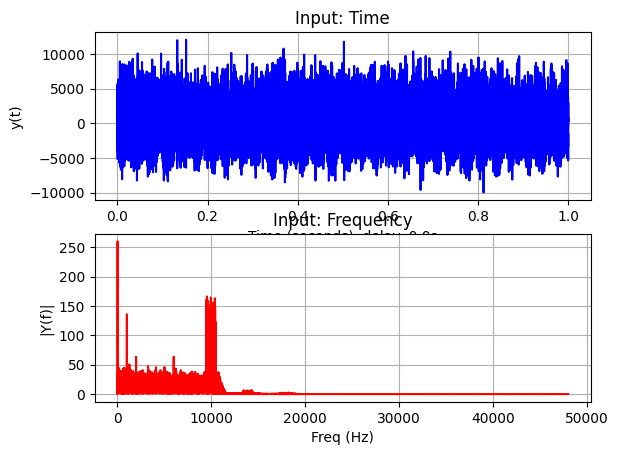

In [46]:
plot_signal(input_signal, "Input")

Lowpass filtering with 699 taps


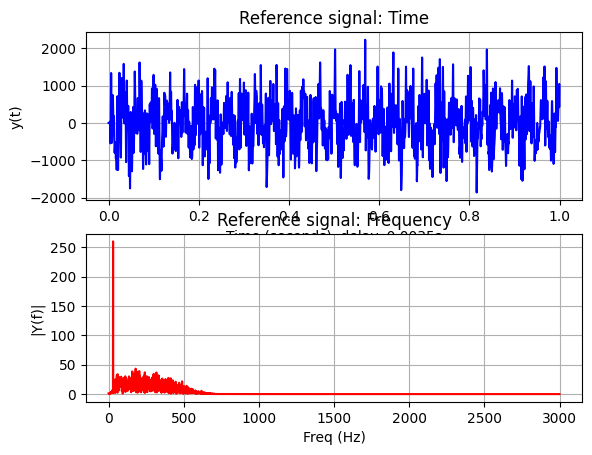

In [47]:
# Filter and decimate reference signal, a 30Hz tone
ref_signal = lowpass(
    input_signal,
    width=500,
    attenuation=60,
    f=500
)
ref_signal = decimate(ref_signal, DECIMATED_RATE)
plot_signal(ref_signal, "Reference signal")

Bandpass filtering with 351 taps


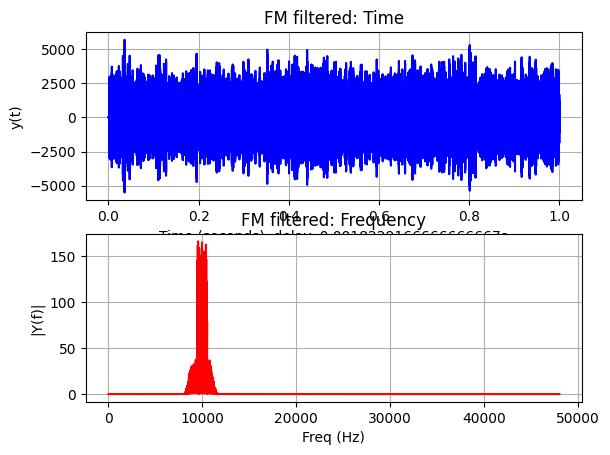

In [48]:
# Filter FM signal
fm_signal = bandpass(
    input_signal,
    width=1000,
    attenuation=60,
    f1=8500,
    f2=11500
)
plot_signal(fm_signal, "FM filtered")

C:\Users\iu2frl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\iu2frl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


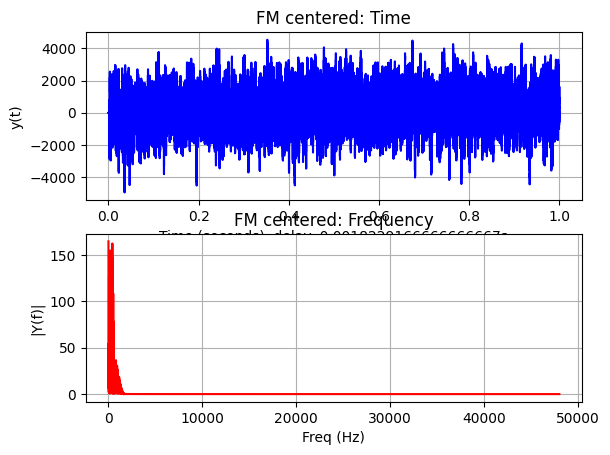

In [49]:
# Center FM signal on 0Hz
carrier = np.exp(-1.0j*2.0*np.pi*9960/fm_signal.rate*np.arange(len(fm_signal.samples)))
fm_signal.samples = fm_signal.samples * carrier
plot_signal(fm_signal, "FM centered")

Lowpass filtering with 699 taps


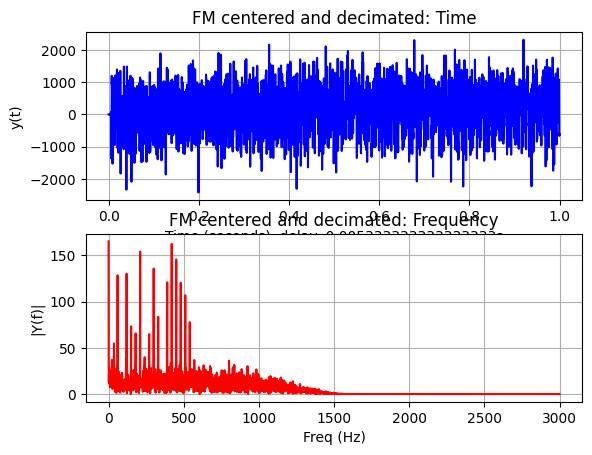

In [50]:
# Lowpass and decimate FM signal
fm_signal = lowpass(
    fm_signal,
    width=500,
    attenuation=60,
    f=1500
)

fm_signal = decimate(fm_signal, DECIMATED_RATE)
plot_signal(fm_signal, "FM centered and decimated")

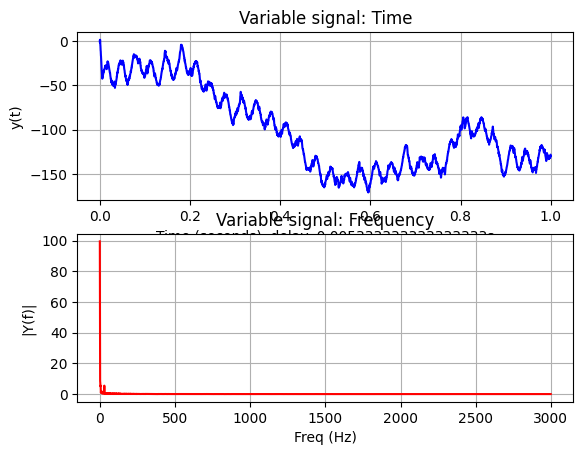

In [51]:
# Get phase of FM signal to get the variable signal
var_signal = Signal(
    np.unwrap(np.angle(fm_signal.samples)),
    fm_signal.rate,
    fm_signal.delay
)
plot_signal(var_signal, "Variable signal")

Bandpass filtering with 1453 taps


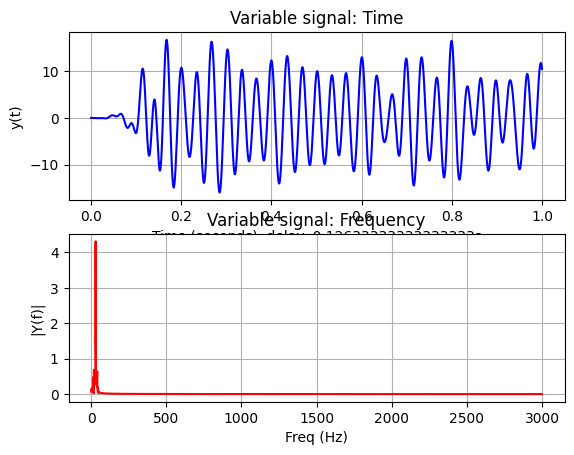

In [52]:
# Remove DC of variable signal
var_signal = bandpass(
    var_signal,
    width=15,
    attenuation=60,
    f1=15,
    f2=45
)

plot_signal(var_signal, "Variable signal")

Bearing: 90.0°


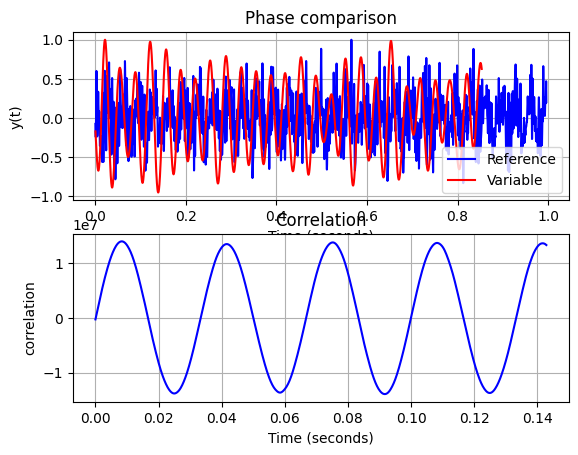

In [53]:
bearing = compare_phases(ref_signal, var_signal)
print("Bearing: {}°".format(bearing))

plt.show()